#Кейс №2 - Приложение доставки

Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Ваша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать одну или несколько метрик, которая отвечает за качество сервиса и статистически сравнить эти метрики в двух группах.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

В данных вы найдете логи заказов пользователей:

[ab_users_data](https://disk.yandex.ru/d/4qY27tJ23G_B1g) – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи

[ab_orders](https://disk.yandex.ru/d/prdO8FDQx7lzCg) – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ

[ab_products](https://disk.yandex.ru/d/atwrlmB_wu-fHA) – подробная информация о продуктах, их название и стоимость

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as scs

import requests
from urllib.parse import urlencode

sns.set(rc={'figure.figsize':(12,6)}, style="darkgrid")

Загрузим данные с помощью Яндекс апи.

In [96]:
def get_ydisk_url(public_key: str) -> str:
  """Returns url from YandexDisc api"""
  base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
  final_url = base_url + urlencode(dict(public_key=public_key))
  response = requests.get(final_url)
  download_url = response.json()['href']
  return download_url

In [97]:
ab_users_data_url = 'https://disk.yandex.ru/d/4qY27tJ23G_B1g'
ab_orders_url = 'https://disk.yandex.ru/d/prdO8FDQx7lzCg'
ab_products_url = 'https://disk.yandex.ru/d/atwrlmB_wu-fHA'

In [98]:
ab_users_data = pd.read_csv(get_ydisk_url(ab_users_data_url))
ab_orders = pd.read_csv(get_ydisk_url(ab_orders_url))
ab_products = pd.read_csv(get_ydisk_url(ab_products_url))

##EDA
Посмотрим на данные и проведем eda.

Рассмотрим данные с историей заказов пользователей.

In [99]:
ab_users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   4337 non-null   int64 
 1   order_id  4337 non-null   int64 
 2   action    4337 non-null   object
 3   time      4337 non-null   object
 4   date      4337 non-null   object
 5   group     4337 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 203.4+ KB


In [100]:
ab_users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


Для удобства работа с датой и временем можно оставить 1 колонку в формате `datetime`.



In [101]:
ab_users_data['timestamp'] = pd.to_datetime(ab_users_data['time'])
ab_users_data = ab_users_data.drop(columns=['time', 'date'])
ab_users_data.head()

,user_id,order_id,action,group,timestamp
0,964,1255,create_order,0,2022-08-26 00:00:19
1,965,1256,create_order,1,2022-08-26 00:02:21
2,964,1257,create_order,0,2022-08-26 00:02:27
3,966,1258,create_order,0,2022-08-26 00:02:56
4,967,1259,create_order,1,2022-08-26 00:03:37


In [102]:
ab_users_data.describe()

,user_id,order_id,group
count,4337.000000,4337.000000,4337.000000
mean,1466.771270,16362.859811,0.610099
std,290.451607,16609.671919,0.487784
min,964.000000,1255.000000,0.000000
25%,1220.000000,2444.000000,0.000000
50%,1463.000000,9615.000000,1.000000
75%,1710.000000,26920.000000,1.000000
max,1980.000000,59533.000000,1.000000


In [103]:
ab_users_data['action'].value_counts()

create_order    4123
cancel_order     214
Name: action, dtype: int64

In [104]:
ab_users_data['group'].value_counts()

1    2646
0    1691
Name: group, dtype: int64

In [105]:
ab_users_data.nunique()

user_id      1017
order_id     4123
action          2
group           2
timestamp    4312
dtype: int64

Посмотрим на данные с информацией о составе заказа.

In [106]:
ab_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   order_id       4123 non-null   int64 
 1   creation_time  4123 non-null   object
 2   product_ids    4123 non-null   object
dtypes: int64(1), object(2)
memory usage: 96.8+ KB


In [107]:
ab_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


Изменим формат даты и сделаем таак чтобы в колонке `product_ids` был список с id продуктов.

In [108]:
ab_orders['creation_time'] = pd.to_datetime(ab_orders['creation_time'])

In [109]:
ab_orders['product_ids'] = (ab_orders['product_ids']
                            .str.strip('{}')
                            .str.split(', ')
                            .apply(lambda x: [int(i) for i in x]))

ab_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"[75, 22, 53, 84]"
1,1256,2022-08-26 00:02:21,"[56, 76, 39]"
2,1257,2022-08-26 00:02:27,"[76, 34, 41, 38]"
3,1258,2022-08-26 00:02:56,"[74, 6]"
4,1259,2022-08-26 00:03:37,"[20, 45, 67, 26]"


In [110]:
ab_orders['order_id'].nunique()

4123

In [111]:
ab_orders.dtypes

order_id                  int64
creation_time    datetime64[ns]
product_ids              object
dtype: object

Изучим данные с информацией о продуктах.

In [112]:
ab_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  87 non-null     int64  
 1   name        87 non-null     object 
 2   price       87 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


In [113]:
ab_products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [114]:
ab_products.describe()

,product_id,price
count,87.000000,87.000000
mean,44.000000,133.581609
std,25.258662,136.127922
min,1.000000,1.000000
25%,22.500000,55.000000
50%,44.000000,76.300000
75%,65.500000,160.000000
max,87.000000,800.000000


Нам пригодится сумма всего заказа в таблице с заказами и колличество товаров в заказе.

In [115]:
products_index = ab_products.set_index('product_id')

In [116]:
ab_orders['order_sum'] = (ab_orders['product_ids']
                          .apply(lambda x:
                                 sum([products_index
                                      .loc[i]['price'] for i in x])))

In [117]:
ab_orders['quantity'] = ab_orders['product_ids'].apply(lambda x: len(x))
ab_orders.head()

,order_id,creation_time,product_ids,order_sum,quantity
0,1255,2022-08-26 00:00:19,"[75, 22, 53, 84]",408.7,4
1,1256,2022-08-26 00:02:21,"[56, 76, 39]",250.5,3
2,1257,2022-08-26 00:02:27,"[76, 34, 41, 38]",310.2,4
3,1258,2022-08-26 00:02:56,"[74, 6]",85.0,2
4,1259,2022-08-26 00:03:37,"[20, 45, 67, 26]",228.0,4


Соеденим таблицу с юзерами с таблицей заказов.

In [118]:
users_orders = ab_users_data.merge(ab_orders, on='order_id', how='left')
users_orders.head()

,user_id,order_id,action,group,timestamp,creation_time,product_ids,order_sum,quantity
0,964,1255,create_order,0,2022-08-26 00:00:19,2022-08-26 00:00:19,"[75, 22, 53, 84]",408.7,4
1,965,1256,create_order,1,2022-08-26 00:02:21,2022-08-26 00:02:21,"[56, 76, 39]",250.5,3
2,964,1257,create_order,0,2022-08-26 00:02:27,2022-08-26 00:02:27,"[76, 34, 41, 38]",310.2,4
3,966,1258,create_order,0,2022-08-26 00:02:56,2022-08-26 00:02:56,"[74, 6]",85.0,2
4,967,1259,create_order,1,2022-08-26 00:03:37,2022-08-26 00:03:37,"[20, 45, 67, 26]",228.0,4


Отберем заказы у которых есть "действие" `cancel_order` и не будем их учитывать при подсчете метрик.

In [119]:
canceled_orders = users_orders[users_orders['action'] == 'cancel_order']\
 ['order_id'].tolist()
len(canceled_orders)

214

In [120]:
users_orders_filtred = (users_orders[~users_orders['order_id']
                                     .isin(canceled_orders)])
users_orders_filtred['action'].value_counts()

create_order    3909
Name: action, dtype: int64

In [121]:
users_orders_filtred.head()

,user_id,order_id,action,group,timestamp,creation_time,product_ids,order_sum,quantity
0,964,1255,create_order,0,2022-08-26 00:00:19,2022-08-26 00:00:19,"[75, 22, 53, 84]",408.7,4
1,965,1256,create_order,1,2022-08-26 00:02:21,2022-08-26 00:02:21,"[56, 76, 39]",250.5,3
2,964,1257,create_order,0,2022-08-26 00:02:27,2022-08-26 00:02:27,"[76, 34, 41, 38]",310.2,4
4,967,1259,create_order,1,2022-08-26 00:03:37,2022-08-26 00:03:37,"[20, 45, 67, 26]",228.0,4
5,968,1261,create_order,0,2022-08-26 00:05:35,2022-08-26 00:05:35,"[30, 35, 69, 6]",430.7,4


Проверим одинаковые данные или нет в колонках `timestamp` и `creation_time`.

In [122]:
users_orders_filtred.shape[0]

3909

In [123]:
(users_orders_filtred['timestamp'] \
 == users_orders_filtred['creation_time']).sum()

3909

Мы видим что количество строк совпадает у двух колонок, значит они одинаковые и мы можем оставить только 1 из них.

Теперь у нас есть таблица, с которой можно проверять гипотезы.

In [124]:
users_orders_filtred = users_orders_filtred.drop(columns=['timestamp'])
users_orders_filtred.head()

,user_id,order_id,action,group,creation_time,product_ids,order_sum,quantity
0,964,1255,create_order,0,2022-08-26 00:00:19,"[75, 22, 53, 84]",408.7,4
1,965,1256,create_order,1,2022-08-26 00:02:21,"[56, 76, 39]",250.5,3
2,964,1257,create_order,0,2022-08-26 00:02:27,"[76, 34, 41, 38]",310.2,4
4,967,1259,create_order,1,2022-08-26 00:03:37,"[20, 45, 67, 26]",228.0,4
5,968,1261,create_order,0,2022-08-26 00:05:35,"[30, 35, 69, 6]",430.7,4


## Графики, гипотезы и тесты.

Исходя из возможностей новой системы рекомендовать пользователям необходимые товары, основной метрикой для сравнения в двух группах A/B теста выберем средний чек в заказе. Также можно посмотреть на колличество покупок в заказе в разных группах.

Для сравнения количества отмененных заказов слишком мало данных.

In [125]:
control_group = users_orders_filtred[users_orders_filtred['group'] == 0]
experimental_group = users_orders_filtred[users_orders_filtred['group'] == 1]

In [126]:
print(f'Колличество пользователей в эксперементальной группе: \
{experimental_group["user_id"].nunique()}\n\n'
      f'Колличество пользователей в контрольной группе: \
{control_group["user_id"].nunique()}')

Колличество пользователей в эксперементальной группе: 501

Колличество пользователей в контрольной группе: 512


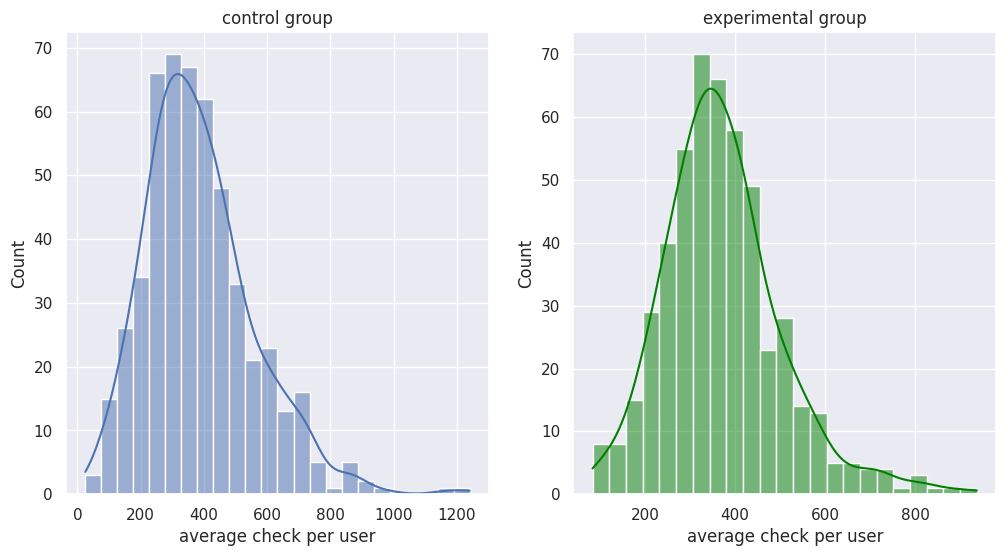

In [127]:
plt.subplot(1, 2, 1)
sns.histplot(control_group.groupby('user_id')['order_sum'].mean(), kde=True)
plt.xlabel('average check per user')
plt.title('control group')
plt.subplot(1, 2, 2)
sns.histplot(experimental_group.groupby('user_id')['order_sum'].mean(),
             color='green', kde=True)
plt.xlabel('average check per user')
plt.title('experimental group')
plt.show()

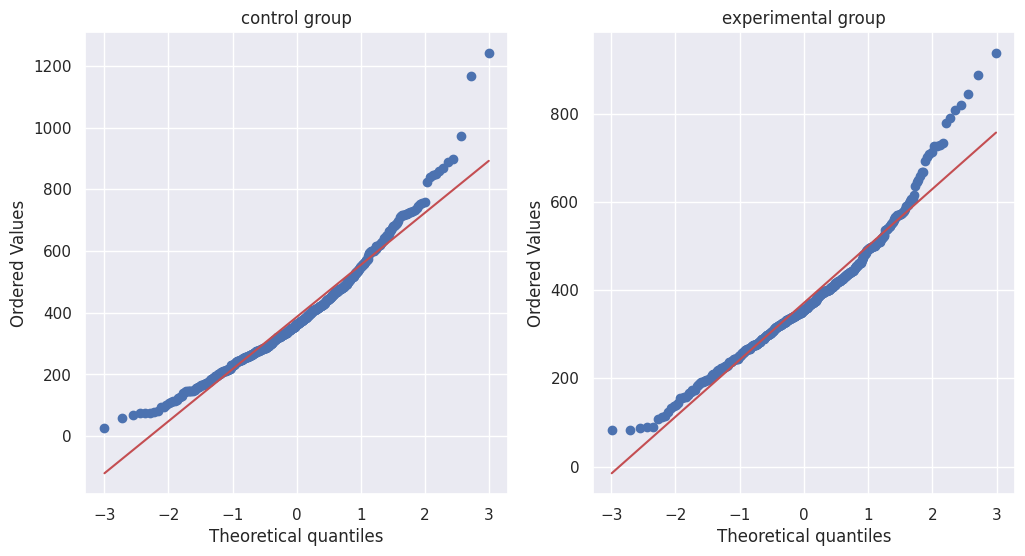

In [128]:
plt.subplot(1, 2, 1)
scs.probplot(control_group.groupby('user_id')['order_sum'].mean(), plot=plt)
plt.title('control group')
plt.subplot(1, 2, 2)
scs.probplot(experimental_group.groupby('user_id')['order_sum'].mean(), plot=plt)
plt.title('experimental group')
plt.show()

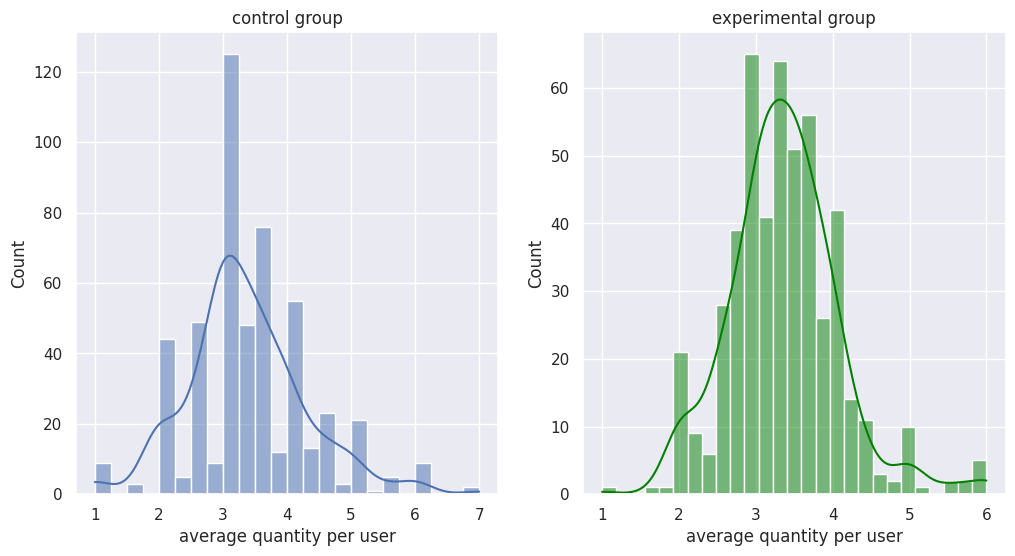

In [129]:
plt.subplot(1, 2, 1)
sns.histplot(control_group.groupby('user_id')['quantity'].mean(),
             kde=True)
plt.xlabel('average quantity per user')
plt.title('control group')
plt.subplot(1, 2, 2)
sns.histplot(experimental_group.groupby('user_id')['quantity'].mean(),
             color='green', kde=True)
plt.xlabel('average quantity per user')
plt.title('experimental group')
plt.show()

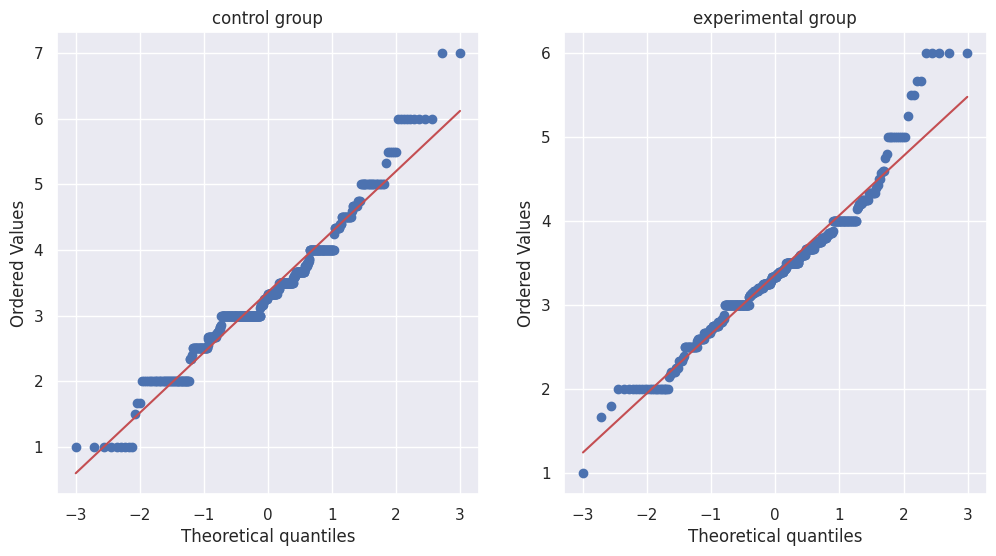

In [130]:
plt.subplot(1, 2, 1)
scs.probplot(control_group.groupby('user_id')['quantity'].mean(), plot=plt)
plt.title('control group')
plt.subplot(1, 2, 2)
scs.probplot(experimental_group.groupby('user_id')['quantity'].mean(), plot=plt)
plt.title('experimental group')
plt.show()

На основании графиков можно сделать выводы что распределение среднего чека имеет "жирные хвосты" и не является нормальным. Распределение среднего количества покупок так же имеет выбросы, но больлше стремиться к нормальному.

Для уверености будем использовать 2 теста T-test и тест Манна-Уитни.

### Сравнение среднего чека

Сравним средний чек в группах с помощью T-test:

- $H_0$: средние значения в группах равны.
- $H_1$: средние значения в группах различаются.

In [131]:
scs.ttest_ind(control_group.groupby('user_id')['order_sum'].mean(),
              experimental_group.groupby('user_id')['order_sum'].mean())

Ttest_indResult(statistic=1.5407052777251002, pvalue=0.12370144988523067)

По результатам T-test мы не можем отклонить 0 гипотезу о равенстве средних.

Посмотрим на различия в группах с помощью Манна-Уитни:

- $H_0$: суммы рангов в группах равны.
- $H_1$: суммы рангов в группах различаются.

In [132]:
scs.mannwhitneyu(control_group.groupby('user_id')['order_sum'].mean(),
                 experimental_group.groupby('user_id')['order_sum'].mean())

MannwhitneyuResult(statistic=130986.5, pvalue=0.5576189838851904)

По результатам теста Манна-Уитни мы не можем отклонить 0 гипотезу.

### Сравнение количества покупок в чеке

Сравним среднее количество покупок в группах с помощью T-test:

- $H_0$: средние значения в группах равны.
- $H_1$: средние значения в группах различаются.

In [133]:
scs.ttest_ind(control_group.groupby('user_id')['quantity'].mean(),
              experimental_group.groupby('user_id')['quantity'].mean())

Ttest_indResult(statistic=-0.1133553419271026, pvalue=0.9097713480198675)

По результатам T-test мы не можем отклонить 0 гипотезу о равенстве средних.

Посмотрим на различия в группах с помощью Манна-Уитни:

- $H_0$: суммы рангов в группах равны.
- $H_1$: суммы рангов в группах различаются.

In [134]:
scs.mannwhitneyu(control_group.groupby('user_id')['quantity'].mean(),
                 experimental_group.groupby('user_id')['quantity'].mean())

MannwhitneyuResult(statistic=124339.0, pvalue=0.39850238989451314)

По результатам теста Манна-Уитни мы не можем отклонить 0 гипотезу.

##Выводы

По результатам проведенных экспериментов мы не смогли найти статистически значимых различий в группах по двум метрикам. Для уверености проводили по 2 теста для каждой метрики.

Основываясь на двух метриках качества сервиса новая система рекомендаций не принесла пользы для бизнеса и пользователей.